# Portfolio-Exam Part I - Sentiment Analysis

* Social Media Analytics - MADS-SMA
* Valentin Werger

In [1]:
# Compare different approaches
# Train own word embedding
# Use model trained on yelp for other data
# Try out sentiments towards types of entities

In [108]:
# Loading required ML packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.downloader

In [3]:
# Read Hamburg Yelp reviews
yelp = pd.read_csv("data/yelp_reviews_hamburg_en.csv", parse_dates=["date"])

In [4]:
# Overview of the data
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     3025 non-null   object        
 1   stars   3025 non-null   float64       
 2   text    3025 non-null   object        
 3   date    3025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 94.7+ KB


In [5]:
# Show the top 5 rows
yelp.head(5)

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [6]:
# Extract name of the location from url
yelp["name"] = yelp.apply(lambda row: re.sub("https://www.yelp.com/biz/", "", row["url"]), axis=1)
yelp = yelp.drop(columns="url")

<AxesSubplot:ylabel='Count'>

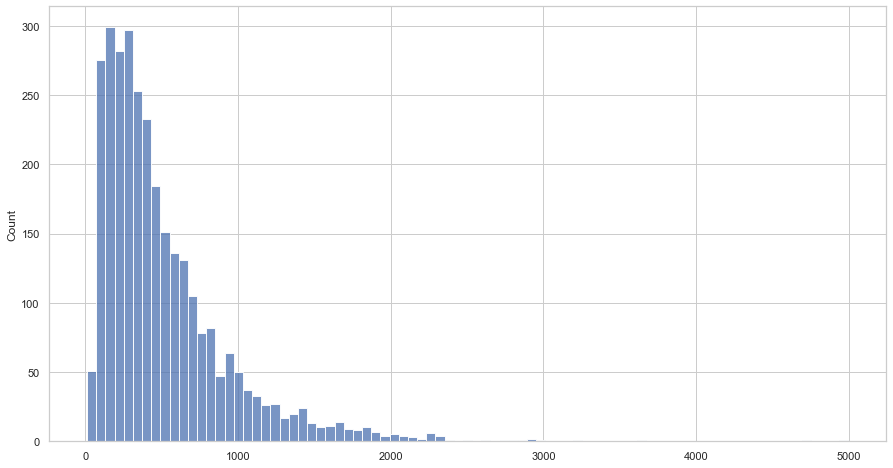

In [7]:
# Inspect length of review text
text_length_distribution = np.array([len(text) for text in yelp.text])

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

# Problem: Maximum length of Bert is 512


In [8]:
# Load potential sets of word vectors
#list(gensim.downloader.info()['models'].keys())
potential_wv = {}
print("Downloading glove-wiki-gigaword-50")
potential_wv["wv_glove_wiki"] = gensim.downloader.load('glove-wiki-gigaword-300')
print("Downloading glove-twitter-50")
potential_wv["wv_glove_twitter"] = gensim.downloader.load('glove-twitter-200')
print("Downloading word2vec-google-news-300")
potential_wv["wv_word2vec"] = gensim.downloader.load('word2vec-google-news-300')

In [35]:
class tester():

    def __init__(self):
        print("init")

    def produce_embeddings(self, X, wv):
        print(wv)
        if wv not in ["wv_glove_wiki","wv_glove_twitter","wv_word2vec"]:
            print("Not a valid set of word vectors - Choose one of the following")
            print(["wv_glove_wiki","wv_glove_twitter","wv_word2vec"])

        vocabulary = set(potential_wv[wv].index_to_key)
        wpt = nltk.WordPunctTokenizer()

        def avg_embeddings(document):
            words = wpt.tokenize(document)
            invocab = [word for word in words if word in vocabulary]
            avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
            return avg

        print(X.text.values)
        doc_embeddings = [avg_embeddings(doc) for doc in X.text.values]
        return doc_embeddings

    def test_function_transformer(self):
        new_transformer = FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"})
        new_transformer.fit_transform(yelp)

In [36]:
new_tester = tester()

init


In [37]:
new_tester.test_function_transformer()

wv_glove_wiki
['fantastic little restaurantgreat staff food good time dining restaurant doesnt menu tells different food day problem making vegetarian option friend made fresh homemade pasta filled pear never tried fantasticthe area outside hansaplatz bit shady people sitting outside drinking day'
 'went grab breakfast cafe also lunch small snacks chose soy yogurt nuts honey found refrigerated section offer two different flavors soy yogurt also quite big tasty looking selection sandwiches bagels display interior nice welcoming prices moderate okay others overpriced 2 fruit infused water great place quick breakfast lunch'
 'good coffee sandwiches yogurts close marriott hotel much better value plenty space friendly staff'
 ...
 'good chinese placethe food premium quality 4 persons took tsingtao menuit consisted soup springrolls duck beef chicken lamb course rice à gogo everything delicious sat table rotating part middle able pass around plates without making mess restaurant cheap worth e

In [134]:
# Sentiment Analyser class
class SentimentAnalyser():

    def __init__(self, data, target, normalize = True):
        self.data = data
        self.target = target
        self.target_distribution = self.data[self.target].value_counts(normalize=True)

        # Normalize the review texts
        if normalize:
            self.data["text"] = self.normalize()

        # Initialize container for experiment results
        self.experiment_results = {}
        self.__run = 1

        # Set up experiments to conduct
        self.experiments = [
            {
                'name': 'Logistic Regression',
                'model': LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5),
                'params': {
                    'preprocessor': [
                        #CountVectorizer(min_df=1), 
                        #CountVectorizer(min_df=2), 
                        #CountVectorizer(min_df=3), 
                        #CountVectorizer(ngram_range=(1,2)),
                        #TfidfVectorizer(norm= 'l1'),
                        #TfidfVectorizer(norm = 'l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
                    'estimator__C': [0.5, 1, 2]
                }
            },
            {
                'name': 'KNeighbors',
                'model': KNeighborsClassifier(algorithm = "auto", n_jobs = os.cpu_count() -1),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm= 'l1'),
                        TfidfVectorizer(norm = 'l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__n_neighbors': randint(1, 10), 
                    'estimator__weights': ["uniform", "distance"], 
                    'estimator__metric': ["euclidean", "manhattan"]
                }
            },
            {
                'name': 'Random Forest',
                'model': RandomForestClassifier(n_jobs = os.cpu_count() -1, verbose = 1, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm= 'l1'),
                        TfidfVectorizer(norm = 'l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__criterion': ['gini', 'entropy'],
                    'estimator__n_estimators': randint(1, 100), 
                    'estimator__max_features': uniform(0.1,0.9),
                    'estimator__class_weight': [None, 'balanced', 'balanced_subsample'],
                    'estimator__ccp_alpha': uniform(0,0.1)
                }
            },
            {
                'name': 'SVM',
                'model': SVC(verbose = True, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm= 'l1'),
                        TfidfVectorizer(norm = 'l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__C': uniform(0.001, 1),
                    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'estimator__degree': randint(1, 5),
                    'estimator__gamma': uniform(0.0001, 1),
                    'estimator__class_weight': [None, 'balanced']
                }
            },
            # When in doubt use XGBoost
            {
                'name': 'XGBoost',
                'model': XGBClassifier(
                    objective = "multi:softprob",
                    num_class = 5, 
                    tree_method = "auto",
                    eval_metric = "auc", 
                    verbosity = 1,
                    use_label_encoder = False,
                    random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm= 'l1'),
                        TfidfVectorizer(norm = 'l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__learning_rate': uniform(0.001, 0.5),
                    'estimator__gamma': uniform(0, 0.5),
                    'estimator__max_depth': randint(3, 10),
                    'estimator__colsample_bytree': uniform(0.5, 0.5)
                }
            }
        ]

    def __normalize_document(self, doc, tokenizer, stop_words):
        doc = re.sub(r'@[\w]+', '', doc)          # replace user mentions
        doc = re.sub(r'http[\S]+', 'URL', doc)    # replace URLs
        doc = re.sub(r'[^\w\s]', '', doc)         # keep words and spaces
        doc = doc.lower()
        doc = doc.strip()
        tokens = tokenizer.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        doc = ' '.join(filtered_tokens)
        return doc

    def normalize(self):
        stop_words = nltk.corpus.stopwords.words('english')
        wpt = nltk.WordPunctTokenizer()

        return self.data.text.apply(lambda x: self.__normalize_document(x, wpt, stop_words))

    def naive_baseline(self):
        self.data["naive_baseline_prediction"] = np.random.choice(self.target_distribution.index.to_numpy(), size = len(yelp), replace = True, p = self.target_distribution.values)

    def vader_sentiment(self):
        vader = SentimentIntensityAnalyzer()
        self.data['vader_scores'] = self.data.text.apply(lambda x: vader.polarity_scores(x))
        self.data['vader_compound'] = self.data.vader_scores.apply(lambda x: x['compound'])
        self.data['vader_prediction'] = self.data.vader_compound.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.vader_prediction, normalize='all')

    def textblob_sentiment(self):
        self.data['textblob_score'] = self.data.text.apply(
            lambda review: TextBlob(review).sentiment[0])
        self.data['textblob_prediction'] = self.data.textblob_score.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.textblob_prediction, normalize='all')

    def produce_embeddings(self, X, wv):
        print(wv)
        if wv not in ["wv_glove_wiki","wv_glove_twitter","wv_word2vec"]:
            print("Not a valid set of word vectors - Choose one of the following")
            print(["wv_glove_wiki","wv_glove_twitter","wv_word2vec"])

        vocabulary = set(potential_wv[wv].index_to_key)
        wpt = nltk.WordPunctTokenizer()

        def avg_embeddings(document):
            words = wpt.tokenize(document)
            invocab = [word for word in words if word in vocabulary]
            avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
            return avg

        doc_embeddings = [avg_embeddings(doc) for doc in X.values]
        print(doc_embeddings)
        return doc_embeddings


    def evaluate_classifier(self, name, model, params, iterations, cv_splits, cv_repeats, use_word_vectors = False):

        class Debug(BaseEstimator, TransformerMixin):

            def transform(self, X):
                print(X)
                print(X.shape)
                self.shape = X.shape
                # what other output you want
                return X

            def fit(self, X, y=None, **fit_params):
                return self
                
        # Setting up the pipeline
        if False:
            pipeline = Pipeline([('oversampler', SMOTE()), ('estimator', model)])
            input = self.produce_embeddings(use_word_vectors)
            params.pop('wordcount__min_df')
            params.pop('wordcount__ngram_range')
            params.pop('tfidf')

        # The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
        pipeline = Pipeline([('preprocessor', CountVectorizer()), ("debug", Debug()), ('oversampler', SMOTE()), ('estimator', model)])

        # Setting up the Cross validation
        inner_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)
        outer_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)

        # Doing hyperparameter optimization
        optimization = RandomizedSearchCV(
            estimator = pipeline,
            param_distributions = params,
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = inner_cv,
            refit = 'roc_auc_ovo_weighted',
            n_iter = iterations,
            n_jobs = os.cpu_count() -1,
            verbose = 1,
            random_state = 33)

        #print(input.shape)
        #print(input)
        #print(self.data[self.target].shape)
        #print(self.data[self.target])
        optimization.fit(self.data.text, self.data[self.target])

        # Evaluating the best model on the outer cross validation
        performance_estimation = cross_validate(
            estimator = optimization,
            X = self.data.text,
            y = self.data[self.target],
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = outer_cv,
            n_jobs = os.cpu_count() -1)

        return(
        {
            'name': name,
            'optimization_cv_results': pd.DataFrame(optimization.cv_results_),
            'best_params': optimization.best_params_,
            'best_model': optimization.best_estimator_,
            'acc': performance_estimation['test_accuracy'],
            'balanced_acc': performance_estimation['test_balanced_accuracy'],
            'f1': performance_estimation['test_f1_weighted'],
            'roc_auc': performance_estimation['test_roc_auc_ovo_weighted']
        }
        )

    def run_experiments(self, iterations, cv_splits, cv_repeats, models = None):

        self.experiment_results[f"run_{self.__run}"] = {}

        # Determine which models to test
        if models:
            experiments = [experiment for experiment in self.experiments if experiment["name"] in models]
        else:
            experiments = self.experiments

        # Run experiment per model type
        for experiment in experiments:

            # Skip SVM
            if experiment['name'] == 'SVM':
                continue

            start_time= time.time()

            print()
            print()
            print(experiment['name'])
            print("-----------------")

            self.experiment_results[f"run_{self.__run}"][experiment['name']] = self.evaluate_classifier(
                    name = experiment['name'],
                    model = experiment['model'],
                    params = experiment['params'],
                    iterations = iterations,
                    cv_splits = cv_splits,
                    cv_repeats = cv_repeats
                )

            end_time = time.time() - start_time
            print(f'Time: {int(round(end_time, 1))} seconds ({int(round(end_time/60, 1))} minutes)')

        self.__run += 1
            

Advantages of pipeline

Convenience and encapsulation
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

Joint parameter selection
You can grid search over parameters of all estimators in the pipeline at once.

Safety
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [135]:
# Initialize the Sentiment Analyser
sentiment = SentimentAnalyser(yelp, "stars", normalize=True)

In [136]:
sentiment.naive_baseline()

In [137]:
sentiment.vader_sentiment()

In [138]:
sentiment.textblob_sentiment()

In [139]:
sentiment.run_experiments(3, 2, 1, ["Logistic Regression"])



Logistic Regression
-----------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [79]:
transformed_data = CountVectorizer().fit_transform(yelp.text)
model = LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5)
model.fit(X = transformed_data, y = yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, n_jobs=7, solver='saga')

In [83]:
model.score(X = transformed_data, y = yelp.stars)

0.9550413223140496

In [106]:
pipeline = Pipeline([('preprocessor', CountVectorizer()), ('oversampler', SMOTE()), ('estimator',  LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5, max_iter=1000))])
pipeline.fit(yelp.text, yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor', CountVectorizer()), ('oversampler', SMOTE()),
                ('estimator',
                 LogisticRegression(l1_ratio=0.5, max_iter=1000, n_jobs=7,
                                    solver='saga'))])

In [107]:
pipeline.score(yelp.text, yelp.stars)

0.9920661157024794

In [113]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yelp.stars, pipeline.predict_proba(yelp.text))

ValueError: multi_class must be in ('ovo', 'ovr')

In [114]:
params = {
    'oversampler': ['passthrough', SMOTE(random_state=33)]
}

inner_cv = RepeatedKFold(n_splits = 2, n_repeats = 1, random_state = 33)
outer_cv = RepeatedKFold(n_splits = 2, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
    cv = inner_cv,
    refit = 'roc_auc_ovo_weighted',
    n_iter = 5,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33)

#print(input.shape)
#print(input)
#print(self.data[self.target].shape)
#print(self.data[self.target])
optimization.fit(yelp.text, yelp.stars)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=2, random_state=33),
                   estimator=Pipeline(steps=[('preprocessor',
                                              CountVectorizer()),
                                             ('oversampler', SMOTE()),
                                             ('estimator',
                                              LogisticRegression(l1_ratio=0.5,
                                                                 max_iter=1000,
                                                                 n_jobs=7,
                                                                 solver='saga'))]),
                   n_iter=5, n_jobs=7,
                   param_distributions={'oversampler': ['passthrough',
                                                        SMOTE(random_state=33)]},
                   random_state=33, refit='roc_auc_ovo',
                   scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                            'roc_auc_ovo'],
                   verbose=1)

In [115]:
optimization.cv_results_

{'mean_fit_time': array([3.50885952, 9.40877807]),
 'std_fit_time': array([0.62279022, 0.69137371]),
 'mean_score_time': array([0.22923148, 0.17882931]),
 'std_score_time': array([0.06071699, 0.02544558]),
 'param_oversampler': masked_array(data=['passthrough', SMOTE(random_state=33)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'oversampler': 'passthrough'},
  {'oversampler': SMOTE(random_state=33)}],
 'split0_test_accuracy': array([0.53139458, 0.48182419]),
 'split1_test_accuracy': array([0.52910053, 0.49801587]),
 'mean_test_accuracy': array([0.53024755, 0.48992003]),
 'std_test_accuracy': array([0.00114703, 0.00809584]),
 'rank_test_accuracy': array([1, 2]),
 'split0_test_balanced_accuracy': array([0.38302699, 0.4135917 ]),
 'split1_test_balanced_accuracy': array([0.35831764, 0.38671666]),
 'mean_test_balanced_accuracy': array([0.37067231, 0.40015418]),
 'std_test_balanced_accuracy': array([0.01235468, 0.01343752]),
 'rank_tes

In [95]:
def produce_embeddings(X, wv):
    print(wv)
    if wv not in ["wv_glove_wiki","wv_glove_twitter","wv_word2vec"]:
        print("Not a valid set of word vectors - Choose one of the following")
        print(["wv_glove_wiki","wv_glove_twitter","wv_word2vec"])

    vocabulary = set(potential_wv[wv].index_to_key)
    wpt = nltk.WordPunctTokenizer()

    def avg_embeddings(document):
        words = wpt.tokenize(document)
        invocab = [word for word in words if word in vocabulary]
        avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
        return avg

    doc_embeddings = [avg_embeddings(doc) for doc in X.values]
    return doc_embeddings

params = {
    'preprocessor': [
        CountVectorizer(min_df=1), 
        CountVectorizer(min_df=2), 
        CountVectorizer(min_df=3), 
        CountVectorizer(ngram_range=(1,2)),
        TfidfVectorizer(norm= 'l1'),
        TfidfVectorizer(norm = 'l2'),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
        FunctionTransformer(produce_embeddings, kw_args={'wv':"wv_word2vec"})
        ],
    'oversampler': ['passthrough', SMOTE(random_state=33)],
    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
    'estimator__C': [0.5, 1, 2]
}

params = {
    'oversampler': ['passthrough', SMOTE(random_state=33)]
}

inner_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)
outer_cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 33)

# Doing hyperparameter optimization
optimization = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
    cv = inner_cv,
    refit = 'roc_auc',
    n_iter = 5,
    n_jobs = os.cpu_count() -1,
    verbose = 1,
    random_state = 33)

#print(input.shape)
#print(input)
#print(self.data[self.target].shape)
#print(self.data[self.target])
optimization.fit(yelp.text, yelp.stars)

# Evaluating the best model on the outer cross validation
performance_estimation = cross_validate(
    estimator = optimization,
    X = yelp.text,
    y = yelp.stars,
    scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
    cv = outer_cv,
    n_jobs = -1)

c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [96]:
optimization.cv_results_

{'mean_fit_time': array([0.5789814 , 1.25538003]),
 'std_fit_time': array([0.13088441, 0.00751984]),
 'mean_score_time': array([0.08575821, 0.0890162 ]),
 'std_score_time': array([0.00524211, 0.00301719]),
 'param_oversampler': masked_array(data=['passthrough', SMOTE(random_state=33)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'oversampler': 'passthrough'},
  {'oversampler': SMOTE(random_state=33)}],
 'split0_test_accuracy': array([nan, nan]),
 'split1_test_accuracy': array([nan, nan]),
 'mean_test_accuracy': array([nan, nan]),
 'std_test_accuracy': array([nan, nan]),
 'rank_test_accuracy': array([1, 2]),
 'split0_test_balanced_accuracy': array([nan, nan]),
 'split1_test_balanced_accuracy': array([nan, nan]),
 'mean_test_balanced_accuracy': array([nan, nan]),
 'std_test_balanced_accuracy': array([nan, nan]),
 'rank_test_balanced_accuracy': array([1, 2]),
 'split0_test_f1': array([nan, nan]),
 'split1_test_f1': array([nan, nan]),

In [71]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["optimization_cv_results"]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,params,split0_test_accuracy,...,split0_test_f1,split1_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.717501,0.000503,0.117499,0.003503,CountVectorizer(),passthrough,none,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1
1,19.886458,0.154257,0.125498,0.019500,CountVectorizer(),SMOTE(random_state=33),l1,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2
2,9.337158,0.070497,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),elasticnet,2,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,3
3,13.607074,1.314542,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,4
4,13.117513,1.867869,0.000000,0.000000,FunctionTransformer(func=<bound method Sentime...,passthrough,none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,NaN,...,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,5
5,1.996702,0.037999,0.209499,0.017500,TfidfVectorizer(norm='l1'),passthrough,l1,2,"{'preprocessor': TfidfVectorizer(norm='l1'), '...",NaN,...,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,6
6,20.287348,0.243974,0.104000,0.019998,CountVectorizer(min_df=3),SMOTE(random_state=33),elasticnet,1,"{'preprocessor': CountVectorizer(min_df=3), 'o...",NaN,...,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7
7,1.538431,0.144711,0.286506,0.023013,TfidfVectorizer(norm='l1'),SMOTE(random_state=33),l2,2,"{'preprocessor': TfidfVectorizer(norm='l1'), '...",NaN,...,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8
8,33.105094,0.957821,0.070483,0.007513,CountVectorizer(),SMOTE(random_state=33),elasticnet,2,"{'preprocessor': CountVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9
9,4.031324,0.361381,0.193499,0.022498,TfidfVectorizer(),passthrough,elasticnet,2,"{'preprocessor': TfidfVectorizer(), 'oversampl...",NaN,...,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10


In [ ]:
sentiment.run_experiments(10, 3, 1, [""])

In [ ]:
sentiment.experiments

In [ ]:
# Sentiment analysis on the document level

# 1. Rule based
    # Vader
    # Text Blob
# 2. ML based - Classification or Regression?
    # own feature engineering plus defined models
        # bag of words
        # TD-IF
        # word vectors
    # Transformers